In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
import pandas as pd

file_path = '/content/drive/MyDrive/archive/gcp_final_approved_dataset.csv'
df = pd.read_csv(file_path)

df.head()


,Resource ID,Service Name,Usage Quantity,Usage Unit,Region/Zone,CPU Utilization (%),Memory Utilization (%),Network Inbound Data (Bytes),Network Outbound Data (Bytes),Usage Start Date,Usage End Date,Cost per Quantity ($),Unrounded Cost ($),Rounded Cost ($),Total Cost (INR)
0,res-ST6BAJ2N,Cloud Dataproc,954.9843,Requests,europe-north1,92.72,70.42,77097035547,8.268593e+10,01-08-2024 22:24,07-08-2024 06:54,5.24,5004.12,5004,415332
1,res-TYGNR0RV,Pub/Sub,479.6348,GB,europe-west1,37.78,46.80,8239357017,1.135149e+10,23-08-2024 09:18,25-08-2024 07:26,9.82,4710.01,4710,390930
2,res-S3I9C869,BigQuery,114.4129,GB,southamerica-east1,82.54,59.47,23358691883,2.345081e+10,18-07-2024 11:13,22-07-2024 00:45,7.37,843.22,843,69969
3,res-1RY9BZ6G,Cloud Endpoints,413.1930,GB,us-central1,86.68,97.63,53404385778,6.078019e+10,20-07-2024 00:15,21-07-2024 10:16,4.41,1822.18,1822,151226
4,res-S3HQYIZ2,Cloud Spanner,335.9892,GB,asia-southeast1,82.95,21.58,10795270461,1.416138e+10,21-08-2024 21:25,25-08-2024 00:21,6.09,2046.17,2046,169818


In [10]:
print(df.columns)


Index(['Resource ID', 'Service Name', 'Usage Quantity', 'Usage Unit',
       'Region/Zone', 'CPU Utilization (%)', 'Memory Utilization (%)',
       'Network Inbound Data (Bytes)', 'Network Outbound Data (Bytes)',
       'Usage Start Date', 'Usage End Date', 'Cost per Quantity ($)',
       'Unrounded Cost ($)', 'Rounded Cost ($)', 'Total Cost (INR)'],
      dtype='object')


In [12]:
df['Usage Start Date'] = pd.to_datetime(df['Usage Start Date'], dayfirst=True)
df = df[['Usage Start Date', 'Service Name', 'CPU Utilization (%)',
         'Memory Utilization (%)', 'Rounded Cost ($)']]


df.columns = ['Date', 'Service', 'CPU_Util', 'Mem_Util', 'Cost']
df.head()


,Date,Service,CPU_Util,Mem_Util,Cost
0,2024-08-01 22:24:00,Cloud Dataproc,92.72,70.42,5004
1,2024-08-23 09:18:00,Pub/Sub,37.78,46.80,4710
2,2024-07-18 11:13:00,BigQuery,82.54,59.47,843
3,2024-07-20 00:15:00,Cloud Endpoints,86.68,97.63,1822
4,2024-08-21 21:25:00,Cloud Spanner,82.95,21.58,2046


In [15]:
print("Cost range:", df['Cost'].min(), "to", df['Cost'].max())
print("CPU_Util:",df['CPU_Util'].min(), "to", df['CPU_Util'].max())
print("Mem_Util:",df['Mem_Util'].min(), "to", df['Mem_Util'].max())

Cost range: 14 to 9004
CPU_Util: 0.05 to 99.97
Mem_Util: 0.06 to 99.81


In [16]:
underutilized = df[(df['CPU_Util'] < 30) &
                   (df['Mem_Util'] < 30) &
                   (df['Cost'] > 500)]

underutilized_summary = underutilized.groupby('Service')['Cost'].sum().reset_index()
underutilized_summary = underutilized_summary.sort_values(by='Cost', ascending=False)

print("Underutilized Services ($):")
print(underutilized_summary)


Underutilized Services ($):
                 Service   Cost
7        Cloud Endpoints  21764
8     Cloud Interconnect  19397
4              Cloud CDN  18668
5      Cloud Data Fusion  16352
14         Cloud Storage  11766
12             Cloud SQL  11472
13         Cloud Spanner  10495
3            Cloud Build   8595
15             Cloud VPC   6690
10     Cloud Memorystore   6541
9   Cloud Load Balancing   5412
20             Firestore   4963
11             Cloud NAT   4385
22               Pub/Sub   3862
1               BigQuery   3814
6         Cloud Dataproc   3503
2            Cloud Armor   2889
0            AI Platform   2568
19              Dataflow   1653
21     Kubernetes Engine   1534
17        Compute Engine    996
16             Cloud VPN    631
18    Container Registry    534


In [17]:
from sklearn.ensemble import IsolationForest

daily_cost = df.groupby('Date')['Cost'].sum().reset_index()

model = IsolationForest(contamination=0.1, random_state=42)
daily_cost['Anomaly'] = model.fit_predict(daily_cost[['Cost']])

spikes = daily_cost[daily_cost['Anomaly'] == -1]
print("Detected Anomalous Days ($):")
print(spikes)


Detected Anomalous Days ($):
                   Date  Cost  Anomaly
20  2024-07-01 16:40:00  6892       -1
52  2024-07-03 07:41:00    14       -1
57  2024-07-03 12:29:00  7499       -1
63  2024-07-03 15:25:00  7284       -1
70  2024-07-03 22:41:00    46       -1
..                  ...   ...      ...
916 2024-08-24 11:01:00  8102       -1
933 2024-08-25 13:28:00  6454       -1
960 2024-08-27 06:09:00  5889       -1
972 2024-08-27 23:02:00    66       -1
973 2024-08-27 23:40:00  4319       -1

[100 rows x 3 columns]


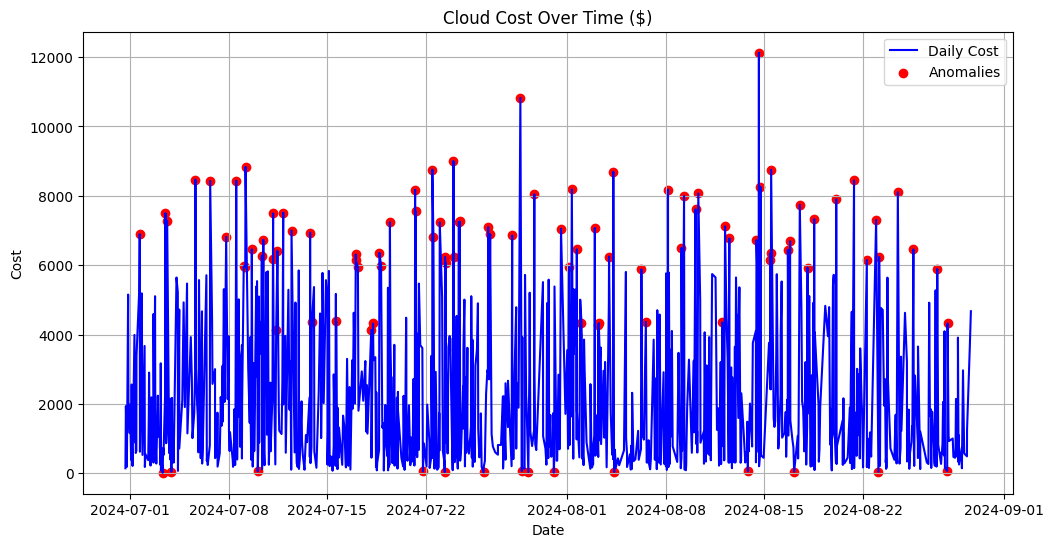

In [23]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_cost, x='Date', y='Cost', label='Daily Cost', color='blue')
plt.scatter(spikes['Date'], spikes['Cost'], color='red', label='Anomalies')
plt.title("Cloud Cost Over Time ($)")
plt.xlabel("Date")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()


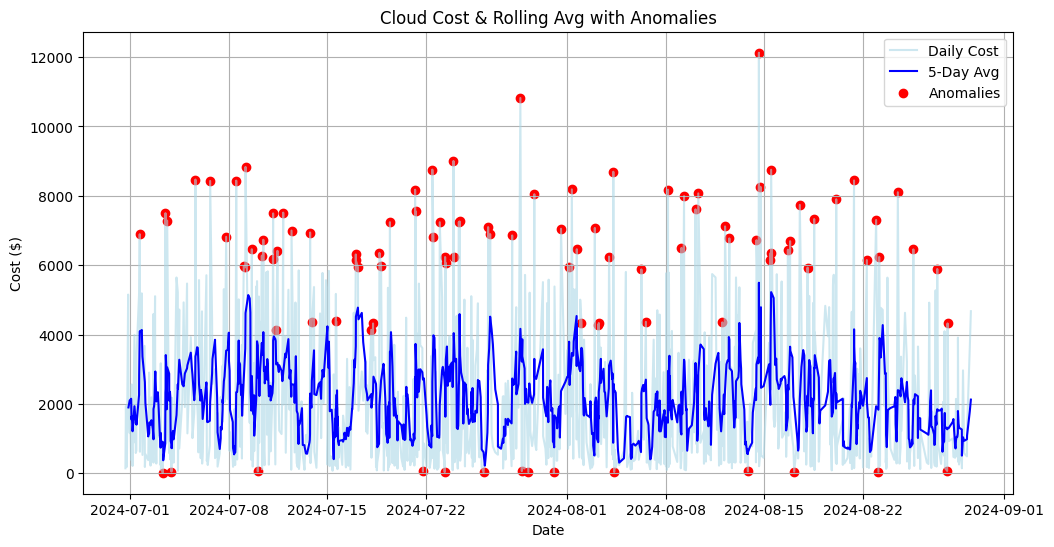

In [24]:
daily_cost['Rolling_Avg'] = daily_cost['Cost'].rolling(window=5).mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_cost['Date'], daily_cost['Cost'], label='Daily Cost', color='lightblue', alpha=0.6)
plt.plot(daily_cost['Date'], daily_cost['Rolling_Avg'], label='5-Day Avg', color='blue')
plt.scatter(spikes['Date'], spikes['Cost'], color='red', label='Anomalies')
plt.title("Cloud Cost & Rolling Avg with Anomalies")
plt.xlabel("Date")
plt.ylabel("Cost ($)")
plt.legend()
plt.grid(True)
plt.show()
